# Quantile Regression

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from utils.tf import f_callback_basic  # Train outside the keras framework

In [2]:
# Constants
SEED = 42  # Reproducibility

plt.rcParams["figure.figsize"]=20,10

tf.random.set_seed(SEED)
np.random.seed(SEED)


experiments = {}  # Where experiments will be stored

## Dataset (synthetic)

Generate a synthetic dataset, taken from [Estimating error prediction (on-the-fly)](01-original-on_the_fly-tf.ipynb).

In [5]:
def relationship_01(x):
    return [2*x[0] + 1]


def gen_x_01(n_samples):
    return [
        tf.random.uniform(
            shape=(n_samples,1),
            minval=0.0,
            maxval=1.0
        )
    ]


def gen_stdev_01(x):
    return [(np.abs(np.sin(x[0] * 4 * np.pi)) * 0.4)]


def f_noise_gaussian_periodic_01(x):
    """Generate noise for labels
    
    RETURN: 
     Tuple of tuples (noise for outputs)
    """
    noise = tf.random.normal(
        shape=x[0].shape,
        mean=0.0,
        stddev=gen_stdev_01(x)[0]
    )
    return([noise])


def f_gen_data(x, f_x2y, f_noise, *args, **kwargs):
    """Generate samples and labels for train and test.
    
    PARAMETERS
    ----------
    x: list of inputs x samples x dim of the input 
        Samples.
    f_x2y: function(x)-> y
        y is a list of outputs x samples x dim of the output
    f_noise: function(x) -> noise to add to y
        Function that generates noise for the outputs.

    RETURN
    ------
    y: list of outputs with noise.
    """    
    return [y+noise for y, noise in zip(f_x2y(x), f_noise(x))]

In [6]:
# Here I will save the data for the original experiment
experiments['original'] = {
    'name': '01-original'
}

experiment = experiments['original']

experiment['data'] = {
    'n_train': 10000,
    'n_test': 2000,
    'f_gen_x': gen_x_01,
    'f_x2y': relationship_01,
    'f_noise': f_noise_gaussian_periodic_01
}


train_x = experiment['data']['f_gen_x'](experiment['data']['n_train'])
train_y = f_gen_data(
    x=train_x,
    f_x2y=experiment['data']['f_x2y'],
    f_noise=experiment['data']['f_noise']
)

test_x = experiment['data']['f_gen_x'](experiment['data']['n_test'])
test_y = f_gen_data(
    x=test_x,
    f_x2y=experiment['data']['f_x2y'],
    f_noise=experiment['data']['f_noise']
)

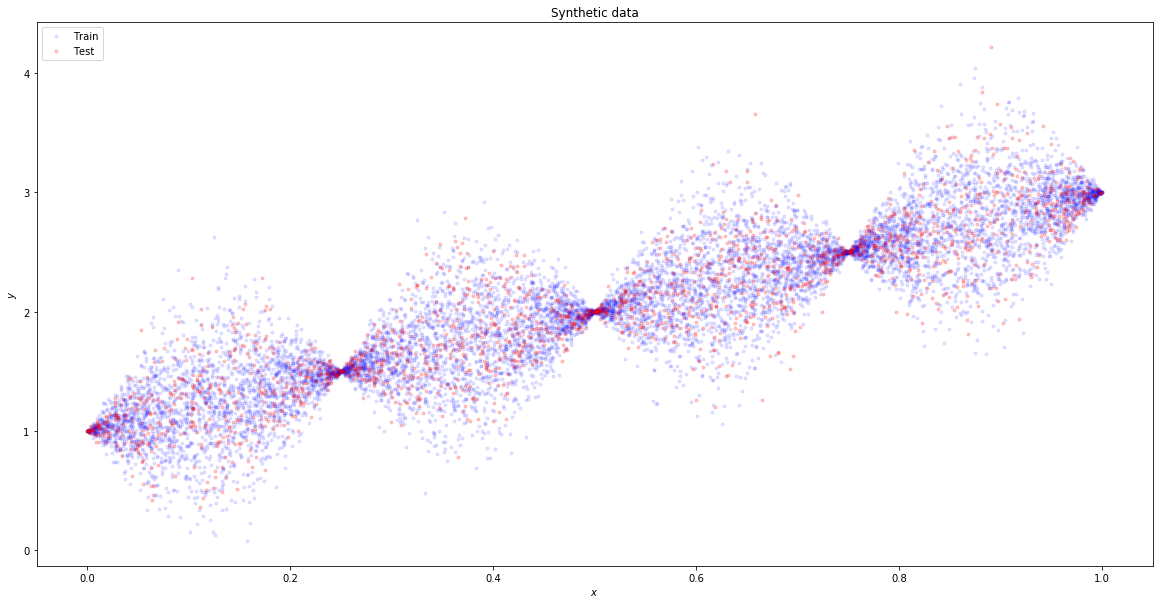

In [7]:
plt.plot(train_x[0], train_y[0], '.', color='blue', label='Train', alpha=0.1)
plt.plot(test_x[0], test_y[0], '.', color='red', label='Test', alpha=0.2)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(loc='upper left', )
plt.title('Synthetic data')
plt.show()

## Model

### Architecture

In [19]:
def get_model_01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="IN_x"
    )
    in_quantile = tf.keras.Input(
        shape=(1,),
        name="IN_q"
    )
    concat_01 = tf.keras.layers.Concatenate(
        name="CONCAT_01"
    )([in_x, in_quantile])
    dense_01 = tf.keras.layers.Dense(
        128,
        name="DENSE_01",
        activation=tf.keras.activations.sigmoid
    )(concat_01)
    dense_02 = tf.keras.layers.Dense(
        32,
        name="DENSE_02",
        activation=tf.keras.activations.sigmoid
    )(dense_01)
    out_y = tf.keras.layers.Dense(
        1,
        name="OUT_y",
        activation=tf.keras.activations.linear
    )(dense_02)
    out_stdev = tf.keras.layers.Dense(
        1,
        name="OUT_stdev",
        activation=tf.keras.activations.linear
    )(dense_02)
    return tf.keras.Model(inputs=[in_x,  in_quantile], outputs=[out_y, out_stdev], name="model_01")

In [20]:
experiment['model'] =  get_model_01()
experiment['model'].summary()

Model: "model_01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_x (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
IN_q (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
CONCAT_01 (Concatenate)         (None, 2)            0           IN_x[0][0]                       
                                                                 IN_q[0][0]                       
__________________________________________________________________________________________________
DENSE_01 (Dense)                (None, 128)          384         CONCAT_01[0][0]           

### Loss

In [ ]:
@tf.function
def loss_pinball(y_true, y_pred, quantiles):
    """TODO
    """
    error = (y_true[0] - y_pred[0])
    return tf.reduce_mean( tf.maximum( quantiles*error, (quantiles-1)*error ) )

### Backpropagation

In [16]:
from tensorflow.python.keras.utils.generic_utils import to_list


def train_step(model, optimizer, f_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = to_list(model(x_train, training=True))
        loss = f_loss( y_train, predictions, quantiles=x_train[-1] )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

### Train

#### Generate batch

In [18]:
def generate_batch(x_train, y_train, n_quantiles):
    """Cartesian product of training points and quantiles sampled from Uniform(0,1).
    """
    n_samples = x_train[0].shape[0]
    quantiles = tf.random.uniform(
        name="Quantile_sampler",
        shape=(n_quantiles,),
        minval=1e-2,
        maxval=1.-1e-2
    )
    # Cartesian product
    x_train_batch = [  # Repeat x features
        tf.repeat(
            input=x,
            repeats=quantiles.shape[0],
            axis=0
        ) for x in x_train
    ]
    x_train_batch.append(
        tf.reshape(  # Flatten
            tf.transpose(  # Shape: n_quantiles, n_samples
                tf.reshape(  # Shape:  n_quantiles, n_samples
                    tf.repeat(  # repeat each quantile n_samples
                        input=quantiles,
                        repeats=n_samples,
                        axis=0
                    ),
                    (n_quantiles, n_samples)
                )
            ),
            (-1,)
        )
    )
    y_train_batch = [
        tf.repeat(
            input=y,
            repeats=quantiles.shape[0],
            axis=0
        )
        for y in y_train
    ]
    return (x_train_batch, y_train_batch)

"""
# TEST:
x_train = [np.vstack([np.arange(64)]*2).transpose()]
y_train = [np.arange(64).reshape(64,1)]*2
x,y = generate_batch(x_train, y_train, 5)
"""

'\n# TEST:\nx_train = [np.vstack([np.arange(64)]*2).transpose()]\ny_train = [np.arange(64).reshape(64,1)]*2\nx,y = generate_batch(x_train, y_train, 5)\n'

In [ ]:
from tensorflow.python.keras.utils.generic_utils import to_list

def train_step(model, optimizer, f_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = to_list(model(x_train, training=True))
        loss = f_loss(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [ ]:
def plot_dists(*dists):
    """Scatter-Plot 2 distributions
    
    PARAMETERS
    ----------
    dists: [([float],[float],string) ]
        x points, y points and color    
    """
    plt.figure(figsize=(14,6))
    for (x,y,color) in dists:
        plt.plot(x, y, '.', color=color, alpha=0.1)
    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.legend([r'Train data','Test data'], loc='upper left', )
    plt.title('Synthetic data')
    plt.show()

In [ ]:
def plot_predictions(x, y_pred, y_var, y_true):
    y_var_margin = 3*(y_var**0.5)  # 3 std deviations captures 99.7% of samples, conservative margin
    plt.figure(figsize=(14,6))
    plt.plot(x, y_true, '.', color='blue', alpha=0.1)
    plt.errorbar(x, y_pred, yerr=y_var_margin, fmt='.', color='green', alpha=0.1);
    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.show()

In [ ]:
def print_metrics(model, loss, true_x, true_y):
    pred = model.predict(true_x)
    print("Loss: {}".format(loss(true_y, pred)))
    plot_predictions(x=true_x[0], y_pred=pred[0], y_var=pred[1], y_true=true_y[0])

In [ ]:
def f_callback_basic(epoch, loss, *args):
    if epoch%100==0:
        print("Epoch: {}\tLoss: {}".format(epoch,loss))

        

def train(model, f_loss, optimizer, batch_size, epochs, x_train, y_train, f_callback=None):
    """Train a model with stochastic gradient descent.
    """

    len_dataset = len(x_train[0])
    indices = tf.range(len_dataset) # All indices for the dataset samples

    for epoch in range(epochs):
        tf.random.shuffle(indices)
        i_batch = 0
        while i_batch<len_dataset:
            batch_indices = indices[i_batch:i_batch+batch_size]  # Stochastic batch selection
            loss = train_step(
                model,
                optimizer,
                f_loss,
                x_train=[
                    tf.gather(params=feat_x, indices=batch_indices)
                    for feat_x in x_train
                ],
                y_train=[
                    tf.gather(params=feat_y, indices=batch_indices)
                    for feat_y in y_train
                ],
            )
            i_batch += batch_size
        if f_callback:
            f_callback(epoch, loss, model)

---

In [ ]:
experiments = dict()  # To save all the data from the experiments

## Original experiment

In this experiment we will try to measure the uncertainty the predictions of a machine learning model.
It is framed into our interest for bayesian methods and in particular bayesian deep learning.


The experiment is based on the work of Steve Thorn. The idea is to add an output, to a neural network, that gives an estimation of the uncertainty of the prediction.


#### References
* Post: [Predicting uncertainty with neural networks](https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d)
* [Original notebook](https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty-variance.ipynb)
* [Local copy of the original notebook](01-Original.ipynb)

In [ ]:
# Here I will save the data for the original experiment
experiments['original'] = {
    'name': '01-original'
}

experiment = experiments['original']

### Generate the synthetic data

Using a synthetic dataset is useful since we can fully control the data generation phenomenon. This way we can test the potentiality of the method.

Dataset properties:

* $x \in \mathbb{R} \in  [0,1)$ sampled uniformly.
* $y \in \mathbb{R} $

The relationship is $y = 2x+1$

In [ ]:
def relationship01(x):
    return 2*x + 1

In [ ]:
def f_xy_lineal(n_samples):
    """Generate samples-labels.
    
    RETURN:
     Tuple of tuples (inputs, outputs), 
    """
    x = tf.random.uniform(
        shape=(n_samples,1),
        minval=0.0,
        maxval=1.0
    )
    return(([x],[relationship01(x)]))

This is our synthetic data without noise.

In [ ]:
x,y = f_xy_lineal(1000)
plot_dists((x[0],y[0],'blue'))

#### Adding uncertainty

Since the previous relationship is easily captured by a linear model (i.e. a linear regression), we will add some noise to add uncertainty in the predictions.

The noise is sampled from a [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with a mean of $0$ and a variance of $1$.

That is $\mathcal{N}(\mu=0.0,\sigma^2=1.0)$


##### Heteroscedasticity
The problem with this noise is that is equally distributed along the dataset. So the prediction error will be homogeneus, it fullfils the assumption of [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity) and the uncertainty could also be measured with a simple linear regression.

So in order to make the error ($\varepsilon$) difficult to measure we will make it dependant on the $x$ value in a periodic manner.

$\varepsilon = \mathcal{N}(\mu=0.0, \sigma^2= (\left| \sin(4*\pi*x) \right| * 0.4)^2)$

Factors explanation
1. Relative scale based on the $x$ value (this adds the heteroscedasticity). It is also periodic.
1. Absolute scale.
1. Gaussian noise.


##### Considerations
1. Every time we sample from the same $x$, there will be different a different $y$.
1. If we make a histogram with $y$ values sampled from the same $x$ it will be a normal distribution centered on the true value of $x$.
1. The error is periodic, not completely [stochastic](https://en.wikipedia.org/wiki/Stochastic).

This is how the variance changes depending on the feature (x).

In [ ]:
# View the period on the variance of the noise

x_sin  = np.linspace(0,1, 1000)
y_sin = (np.abs(np.sin(x_sin * 4 * np.pi)) * 0.4)**2

plot_dists( (x_sin, y_sin, 'green') )

In [ ]:
def f_noise_gaussian_periodic(samples_x):
    """Generate noise for labels
    
    RETURN: 
     Tuple of tuples (noise for outputs)
    """
    noise = tf.random.normal(
        shape=samples_x[0].shape,
        mean=0.0,
        stddev=np.abs(np.sin(samples_x[0] * 4 * np.pi)) * 0.4
    )
    return([noise])

#### Generate the data

In [ ]:
experiment['data'] = {
    'n_train': 10000,
    'n_test': 2000,
    'f_xy': f_xy_lineal,
    'f_noise': f_noise_gaussian_periodic
}

In [ ]:
(train_x, train_y), (test_x, test_y) = f_gen_data(**experiment['data'])

#### Visualize the data

The blue dots are training data, and the red dots are testing data, we see they come from the same population.

In [ ]:
plot_dists(
    (train_x[0], train_y[0], 'blue'),
    (test_x[0], test_y[0], 'red')
)

### Model

The candidate model is an [ANN](https://en.wikipedia.org/wiki/Artificial_neural_network), since it can model non-linearities it should be able to fit an error estimation.

There will be 2 outputs.
* y_pred: the prediction $\hat{y}$
* y_var: the prediction error variance $(y-\hat{y})^2$


#### Definition

In [ ]:
def get_model01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="x"
    )
    f1 = tf.keras.layers.Dense(
        1000,
        name="hidden",
        activation=tf.keras.activations.relu
    )(in_x)
    out_y = tf.keras.layers.Dense(
        1,
        name="y_pred",
        activation=tf.keras.activations.linear
    )(f1)
    out_var = tf.keras.layers.Dense(
        1,
        name="y_var",
        activation=tf.keras.activations.linear
    )(f1)
    return tf.keras.Model(inputs=[in_x], outputs=[out_y, out_var], name="model01")

In [ ]:
experiment['model'] =  get_model01()
experiment['model'].summary()

**Note**

We have 4002 parameters to fit 10000 data points and the uncertainty in the estimation. Since the relationship is linear $y = ax + b$ (only 2 parameters needed to predict $x$, or y_pred), there are 4000 parameters dedicated to the error prediction, that is a rate of 2 free parameters to 5 data points. Overfitting warning.

#### Loss function

We will use [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function. As there are two outputs the total loss will be the mean of the losses.

In [ ]:
def loss01(y_true, y_pred):  # Candidate 1
    y_pred_sqr_error = (y_true[0]-y_pred[0])**2
    return tf.reduce_mean(
        y_pred_sqr_error +
        (y_pred_sqr_error - y_pred[1])**2 
    )

In [ ]:
def loss02(y_true, y_pred):  # Candidate 2
    y_pred_sqr_error = (y_true[0]-y_pred[0])**2
    return (
        tf.reduce_mean(y_pred_sqr_error) +
        tf.reduce_mean((y_pred_sqr_error - y_pred[1])**2)
    )

##### Pick the fastest

In [ ]:
pred_y = experiment['model'].predict(train_x)

In [ ]:
%%timeit

loss01(train_y, pred_y)

In [ ]:
%%timeit

loss02(train_y, pred_y)

In [ ]:
experiment['loss'] = loss01  # Faster

##### Tests

In [ ]:
loss01(train_y, pred_y)

In [ ]:
loss02(train_y, pred_y)

In [ ]:
# A small test
assert(loss01(train_y, pred_y)-loss02(train_y, pred_y)<0.00001)  # Same value
assert(pred_y[0].shape==pred_y[1].shape)
print(pred_y[0].shape)

#### Train the model

In [ ]:
experiment['hyper'] = {  # Hyperparameters
    'optimizer': tf.keras.optimizers.Adam(
        learning_rate=1e-4,
    ),
    'bs': experiments['original']['data']['n_train'],  # Whole dataset
    'epochs': 6000
}

##### Classic Keras

**NOTE**

If I try...
```python
experiments['original']['model'].fit(
    x=train_x,
    y=train_y,
    batch_size=experiments['original']['hyper']['bs'],
    epochs=experiments['original']['hyper']['epochs'],
)
```

Keras complains the target shape is not as expected.
```
ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor:...
```

`F**k` keras, do the check on the returned value from the loss function!!!! Not on the training data.

*NOTE: the problem is train_y.shape is not the same as the shape from the otput model.*

##### Au naturel

In [ ]:
train(
    model=experiment['model'],
    f_loss=experiment['loss'],
    optimizer=experiment['hyper']['optimizer'],
    batch_size=experiment['hyper']['bs'],
    epochs=experiment['hyper']['epochs'],
    x_train=train_x,
    y_train=train_y,
    f_callback=f_callback_basic
)

#### Tests

##### Training set

In [ ]:
print_metrics(experiment['model'], experiment['loss'], train_x, train_y)

##### Testing set

In [ ]:
print_metrics(experiment['model'], experiment['loss'], test_x, test_y)

### Conclusion

I have found **NO EVIDENCE** to say the technique works. The captured variance is homoscedastic, the confidence margins per point are the same all along the dataset.

This causes a disonance because the [original implementation](00-original_pytorch.ipynb) in Pytorch seems to work differently. But, as I have not been able to replicate the behaviour I can't continue that path.

The next figure shows the **captured variance** per point, the shape should resemble the curve we build in the section [Adding uncertainty](#Adding-uncertainty).

In [ ]:
pred = experiment['model'].predict(train_x)
plot_dists((train_x[0], pred[1], 'blue') )

## Minibatches

One thing that could be causing trouble is to use the whole dataset (batch) in a single optimization step. In this experiment I will use a minibatch approach to ease the convergence and test the modelling capabilities.

I start on a copy of the previous experiment.

In [ ]:
experiment = experiments['minibatches'] = {
    'name': '02-minibatches',
    'data': experiments['original']['data'].copy(),
    'hyper': experiments['original']['hyper'].copy(),
    'loss': experiments['original']['loss'],
    'model': get_model01()  # Start with a fresh model
}

experiment['hyper']['optimizer'] = tf.keras.optimizers.Adam(  # Start with a fresh optimizer
    learning_rate=1e-4,
)

### Changes

I will use a 1024-sample batch size.

**Note**

At first I trained the model for the same number of epochs and tracked the evolution of the **variance curve**, I saw it resembled the [original one](#Considerations) so I trained for a longer number of epochs until the model was properly fit.

In [ ]:
experiment['hyper']['bs'] = 1024  # Reduce the batch size to ease the convergence
experiment['hyper']['epochs'] *= 6  # There are no significant changes if 5 is used

### Model

#### Train

In [ ]:
train(
    model=experiment['model'],
    f_loss=experiment['loss'],
    optimizer=experiment['hyper']['optimizer'],
    batch_size=experiment['hyper']['bs'],
    epochs=6000,#experiment['hyper']['epochs'],
    x_train=train_x,
    y_train=train_y,
    f_callback=f_callback_basic
)

In [ ]:
# Save
tf.saved_model.save(experiment['model'], 'models/'+experiment['name'])

#### Tests

##### Captured variance

In [ ]:
plot_dists((
    train_x[0],
    experiment['model'].predict(train_x)[1],
    'blue')
)

##### Training set

In [ ]:
print_metrics(experiment['model'], experiment['loss'], train_x, train_y)

##### Testing set

In [ ]:
print_metrics(experiment['model'], experiment['loss'], test_x, test_y)

### Here comes Bayes

#### Priors?

#### The result

This is Bayesian statistics, so...




Conseguir intervalos por acumulación
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
scipy.stats.norm.interval


In [ ]:
experiment['model']  = tf.saved_model.load('models/'+experiment['name'])

### Conclusion

Why does it takes so long to train?

loss function, variance does not seem to affect much, other scale


[variance](https://en.wikipedia.org/wiki/Variance) is a [second moment](https://en.wikipedia.org/wiki/Moment_(mathematics)) magnitude
Proposition
2-step

## Loss Function Changes

In [ ]:
# Here I will save the data for the original experiment
experiments['loss'] = {
    'name': '02-loss',
    'data': experiments['original']['data'].copy(),
    'hyper': experiments['original']['hyper'].copy(),  # Do not keep the optimizer!
    'model': get_model01()
}

experiment = experiments['loss']

experiment['hyper']['optimizer'] = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
)

In [ ]:
def loss01(y_true, y_pred):  # Candidate 1
    loss_y_pred = tf.reduce_mean(y_true[0]-y_pred[0])**2
    loss_y_var = tf.reduce_mean( ((y_true[0]-y_pred[0])**2 - y_pred[1])**2 )
    
    
    y_pred_sqr_error = (y_true[0]-y_pred[0])**2
    return tf.reduce_mean(
        y_pred_sqr_error +
        (y_pred_sqr_error - y_pred[1])**2 
    )

## Two steps

In [ ]:
TODO

[] crear librería
[]

opciones
2 steps
función de pérdida


pasar función de train a lib


Creo que los errores de  varianza y predicción no están en la misma escala.
¿Puedo balancearlos?


Problemas

Cómo ajustar una varianza de una predicción mala, no tiene sentido
Magnitud predicción vs varianza 
Conclusión, al vuelo no tiene sentido.



EXP2
Modelo en dos fases
Entrenar modelo predicción
Entrenar modelo varianza



## References

### Quantile Regression
* [Wikipedia - Quantile](https://en.wikipedia.org/wiki/Quantile)
* [ResearchGate - Kernel Conditional Quantile Estimation via Reduction Revisited](https://www.researchgate.net/publication/220766517_Kernel_Conditional_Quantile_Estimation_via_Reduction_Revisited)
* [Quantile Regression—Theory, Implementations, and Applications](https://www.youtube.com/watch?v=GddvdXMJV9Y)
* Quantile Regression - University of Copenhagen
  * [An introduction](https://www.youtube.com/watch?v=pAKwoz05lK4)
  * [The model](https://www.youtube.com/watch?v=L9qexifUKCw)
  * [The criterion function](https://www.youtube.com/watch?v=sgR55l054DQ)
  * [Pharmaceutical example](https://www.youtube.com/watch?v=D2SzCv02Jv8)
* [eco621] Quantile regression: 
[01](https://www.youtube.com/watch?v=-D2JkIh0MJI), 
[02](https://www.youtube.com/watch?v=Bm4ibgSatGo), 
[03](https://www.youtube.com/watch?v=wIVxnEvggDM), 
[04](https://www.youtube.com/watch?v=lDbPftcWKsQ), 
[05](https://www.youtube.com/watch?v=c_9BT04o1nU), 
[06](https://www.youtube.com/watch?v=YLiHfy0dFEM), 
[07](https://www.youtube.com/watch?v=kqfk21wVxaY), 
[08](https://www.youtube.com/watch?v=mAXlMnV_QCY), 
[09](https://www.youtube.com/watch?v=XFNuFyIK_v4), 
[10](https://www.youtube.com/watch?v=IHuTk-ksYl4), 
[11](https://www.youtube.com/watch?v=rWG4k6Lb-TI) and 
[12](https://www.youtube.com/watch?v=yvJQNTE9ptU)
* [Three Things You Should Know about Quantile Regression](https://www.youtube.com/watch?v=CU0ofd3hSOA)
* Applications
  * [Application of quantile regressions to modelling spatial distributions](https://www.youtube.com/watch?v=XvHQTBQTv6c)
  * [Quantile Regression in Ecology](https://www.youtube.com/watch?v=k8mZrNoKFIg)
  * [IV Quantile Regression for Group-Level Treatments](https://www.youtube.com/watch?v=1ngRz6YH6_U)
  
  
### Pinball Loss
* [Quantile loss function for machine learning](https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/)
* [arXiv - Estimating conditional quantiles with the help of the pinball loss](https://arxiv.org/abs/1102.2101)